In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling **single-point input prompts** in a grid over the image, from each of which SAM can **predict multiple masks**. Then, **masks are filtered for quality and deduplicated using non-maximal suppression**. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    !wget -P images https://raw.githubusercontent.com/A1exan10er/segment-anything/main/notebooks/images/USB.jpg # This is a self-defined image from the forked GitHub repo

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-i2jg9dgh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-i2jg9dgh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2024-06-01 18:31:02--  https://raw.githubusercontent.com/A1exan10er/segment-anything/main/notebooks/images/USB.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3724 (3.6K) [image/jpeg]
Saving to: ‘images/USB.jpg’

USB.jpg    

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) # lambda是一种小型、匿名的、内联函数，它可以具有任意数量的参数，但只能有一个表达式
                                                                        # This line sorts the anns list in descending order based on the 'area' value
                                                                        # of each annotation dictionary. It uses the sorted function with a custom key
                                                                        # function that takes each annotation dictionary x and returns its 'area' value.
                                                                        # The reverse=True argument sorts the list in descending order.
    ax = plt.gca() # Matplotlib axis
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4)) # This creates a blank image with an alpha channel.
    img[:,:,3] = 0 # The alpha channel is initially set to 0 (transparent).

    # This loops through each annotation, creates a random color with an alpha value of 0.35, and applies it to the segmentation mask.
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img) # This displays the image with the applied annotations.

In [ ]:
def show_ann(ann):
    """
    Visualize a single annotation on an image using Matplotlib.

    Parameters:
    ann (dict): An annotation dictionary containing 'segmentation' (numpy array) and 'area' (float).
    """
    if not ann:
        return

    # Prepare the plot
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create a blank image with an alpha channel
    img = np.ones((ann['segmentation'].shape[0], ann['segmentation'].shape[1], 4))
    img[:, :, 3] = 0

    # Apply the annotation to the image
    m = ann['segmentation']
    color_mask = np.concatenate([np.random.random(3), [0.35]])
    img[m] = color_mask

    # Display the image with annotation
    ax.imshow(img)


## Example image

In [ ]:
# image = cv2.imread('images/dog.jpg') # Read image from path
# image = cv2.imread('images/pensil.jpeg')
image = cv2.imread('images/USB.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # The reason for this conversion is that OpenCV, by default, loads images in the BGR color order, which is different from the RGB color order typically used in many other image processing libraries and applications.
                                               # This conversion is essential if you want to display the image using libraries like Matplotlib or PIL (Python Imaging Library), which expect the image data to be in the RGB format. It's also necessary if you want to perform operations that rely on the RGB color space, such as color filtering or color-based object detection.

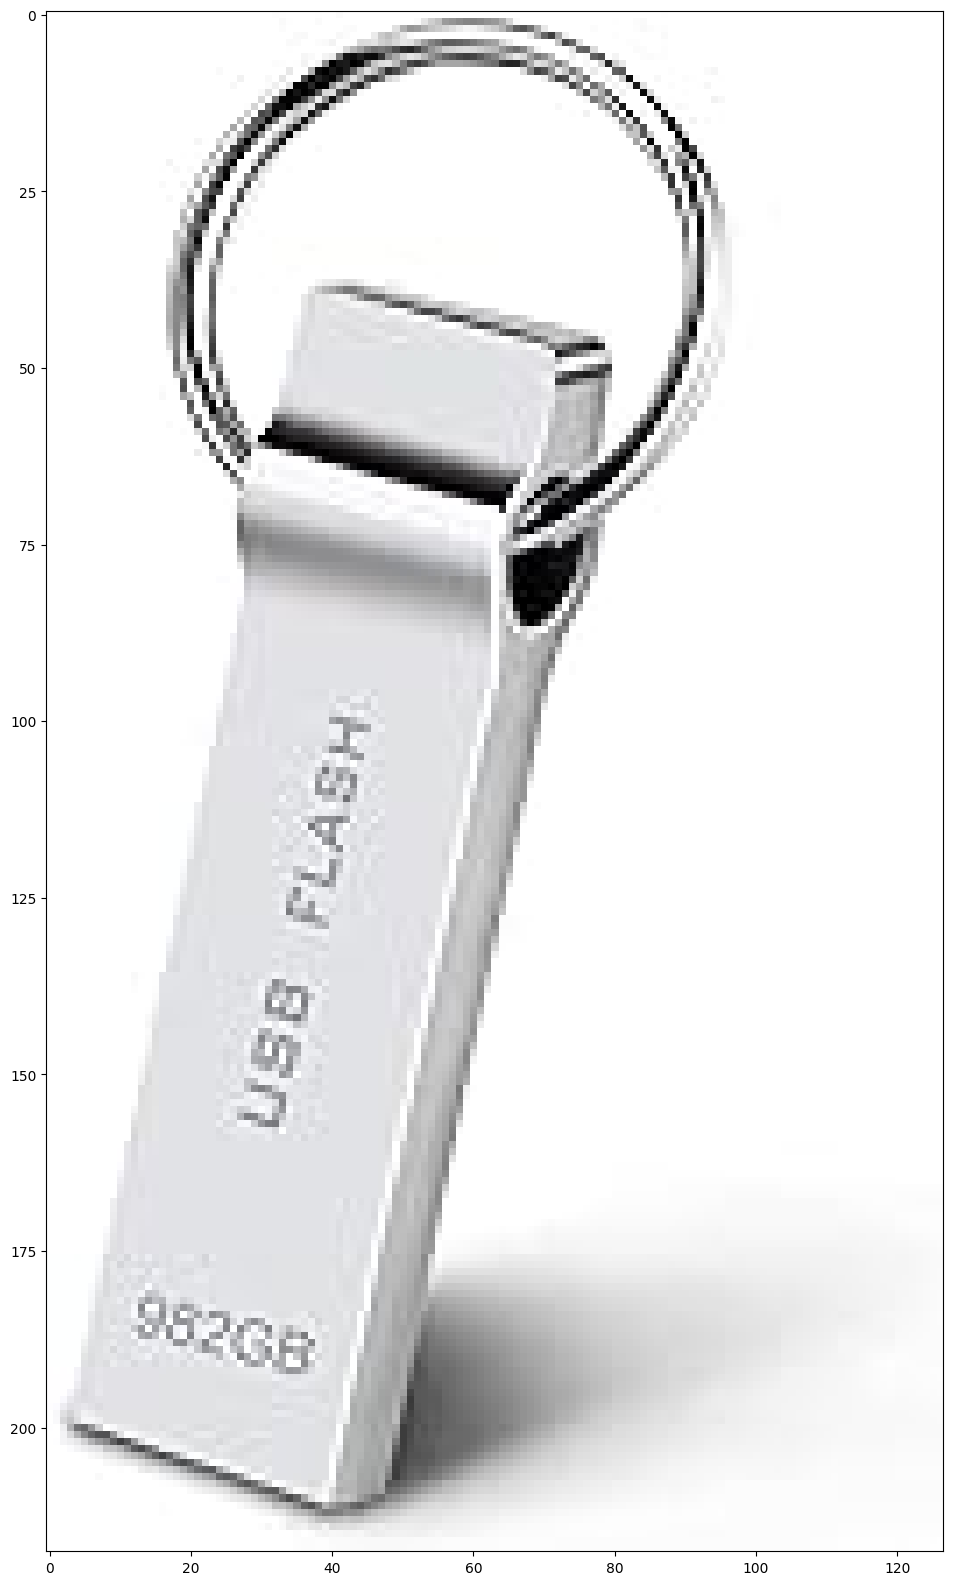

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
# plt.axis('off')
plt.axis('on')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
# import sys
# sys.path.append("..")
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

# device = "cuda"

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import sys
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Add parent directory to system path to import segment_anything module
sys.path.append("..")

# Define model checkpoint and type
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model from the registry using the specified checkpoint
try:
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    print(f"Model type: '{model_type}', checkpoint: '{sam_checkpoint}'")
except KeyError:
    raise ValueError(f"Model type '{model_type}' is not available in the registry.")

# Move the model to the specified device
sam.to(device=device)

# Initialize the mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

print(f"Model loaded and moved to {device}. Mask generator is ready.")


Model type: 'vit_h', checkpoint: 'sam_vit_h_4b8939.pth'
Model loaded and moved to cuda. Mask generator is ready.


To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image) # 'masks' is the argument 'anns' of function 'show_anns'

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks)) # Number of masks
print(masks[0].keys())

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
print(type(masks)) # Type of 'masks' is list
print(type(masks[0])) # Type of each element in 'masks' is 'dict'
print(len(masks[0])) # Number of key:value pairs in a single mask element

# # Compare 'masks[0]' and 'masks[1]'
# print("Area0: ", masks[0].get('area'))
# print("Area1: ", masks[1].get('area'))
# print("masks[0] bbox: ", masks[0].get('bbox')) # Get the bbox value XYWH of mask[0], maybe useful at sythesising
# print("masks[1] bbox: ", masks[1].get('bbox'))
# print("masks[0] crop_box: ", masks[0].get('crop_box')) # Crop box to generate this mask
# print("masks[1] crop_box: ", masks[1].get('crop_box'))
mask_unsorted_list = []
for i in range(6):
  print(f"Area {i}: ", masks[i].get('area'))
  print(f"bbox of masks {i}: ", masks[i].get('bbox'))
  print(f"crop_box of masks {i}: ", masks[i].get('crop_box'))
  mask_unsorted_list.append(masks[i])
print(mask_unsorted_list)
# Sort mask list in 'area' descending order
mask_sorted_list = sorted(mask_unsorted_list, key=(lambda x: x['area']), reverse=True)
print(mask_sorted_list)

# Values in dictionary 'masks'
# Dictionary structure is key:value
print(f'Single value in {masks[0].get("bbox")}')
print("Key 'segmentation' shape in masks[0]: ", masks[0].get('segmentation').shape)
print("Key 'segmentation' shape in masks[1]: ", masks[1].get('segmentation').shape)
print("Key 'segmentation' in masks[0]: \n", masks[0].get('segmentation')) # Segmentation is the mask, so in order to show mask on image, draw the segmentation on image
print("Key 'segmentation' in masks[1]: \n", masks[1].get('segmentation'))

<class 'list'>
<class 'dict'>
7
Area 0:  17979
bbox of masks 0:  [0, 0, 125, 217]
crop_box of masks 0:  [0, 0, 127, 218]
Area 1:  6232
bbox of masks 1:  [3, 62, 68, 148]
crop_box of masks 1:  [0, 0, 127, 218]
Area 2:  4230
bbox of masks 2:  [1, 166, 125, 51]
crop_box of masks 2:  [0, 0, 127, 218]
Area 3:  1268
bbox of masks 3:  [17, 1, 78, 75]
crop_box of masks 3:  [0, 0, 127, 218]
Area 4:  178
bbox of masks 4:  [12, 181, 25, 11]
crop_box of masks 4:  [0, 0, 127, 218]
Area 5:  1087
bbox of masks 5:  [31, 39, 48, 30]
crop_box of masks 5:  [0, 0, 127, 218]
[{'segmentation': array([[False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False]]), 'area': 17979, 'bbox': [0, 0, 125, 217], 'predicted_iou': 1.01702070236

Show all the masks overlayed on the image.

[{'segmentation': array([[False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False]]), 'area': 17979, 'bbox': [0, 0, 125, 217], 'predicted_iou': 1.0170207023620605, 'point_coords': [[1.984375, 3.40625]], 'stability_score': 0.9893869757652283, 'crop_box': [0, 0, 127, 218]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 6232, 'bbox': [3, 62, 68, 148], 'predicted_iou': 0.9991719722747803, '

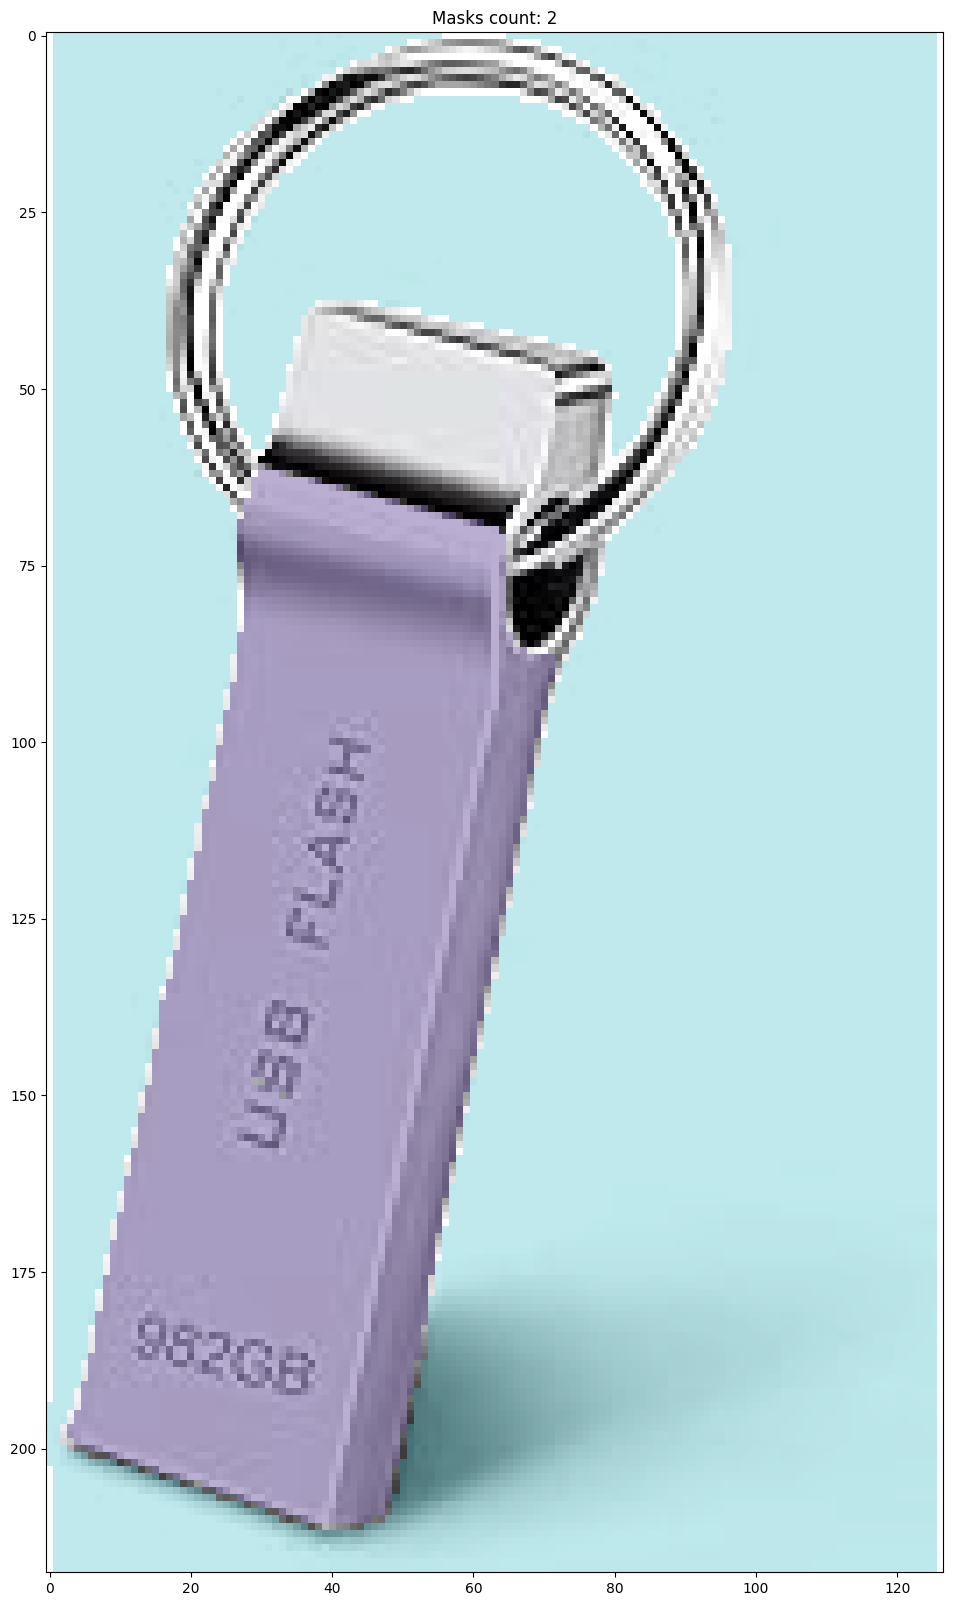

In [ ]:
plt.figure(figsize=(20,20)) # Create plot with size 20 X 20 inches
plt.imshow(image)
# show_anns(masks)

# # How to only plot one single mask?
# show_ann(masks[0])

# # Show some masks to compare with each other and help to identify parameters
# for i in range(2):
#   show_ann(masks[i])
#   print(f"Draw mask {i}")
mask_list = [masks[i] for i in range(2)]
print(mask_list)
show_anns(mask_list)

# # Display all masks one-by-one according to length of 'masks'
# for i in range(len(masks)):
#   show_ann(masks[i])

"""
Attention:
Masks don't erase overlap automatically. For example, the whole dog's mask is masks[0], while dog's ears, tongue, eye are other separate masks.
"""

# plt.axis('off')
plt.axis('on')
plt.title(f'Masks count: {len(mask_list)}') # Add title to plot
plt.show()

## Automatic mask generation options

There are **several tunable parameters** in automatic mask generation that control how densely points are sampled and what the thresholds are for **removing low quality or duplicate masks**. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
# len(masks2)

print(len(masks2)) # Number of masks2
print(masks2[0].keys())

print(masks2[0].get('bbox')) # Get the bbox value XYWH of mask[0], maybe useful at sythesising
print(masks2[0].get('crop_box')) # Crop box to generate this mask
print(masks2[0].get('point_coords'))

23
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[12, 181, 25, 11]
[0.0, 88.0, 85.0, 130.0]
[[23.90625, 189.5625]]


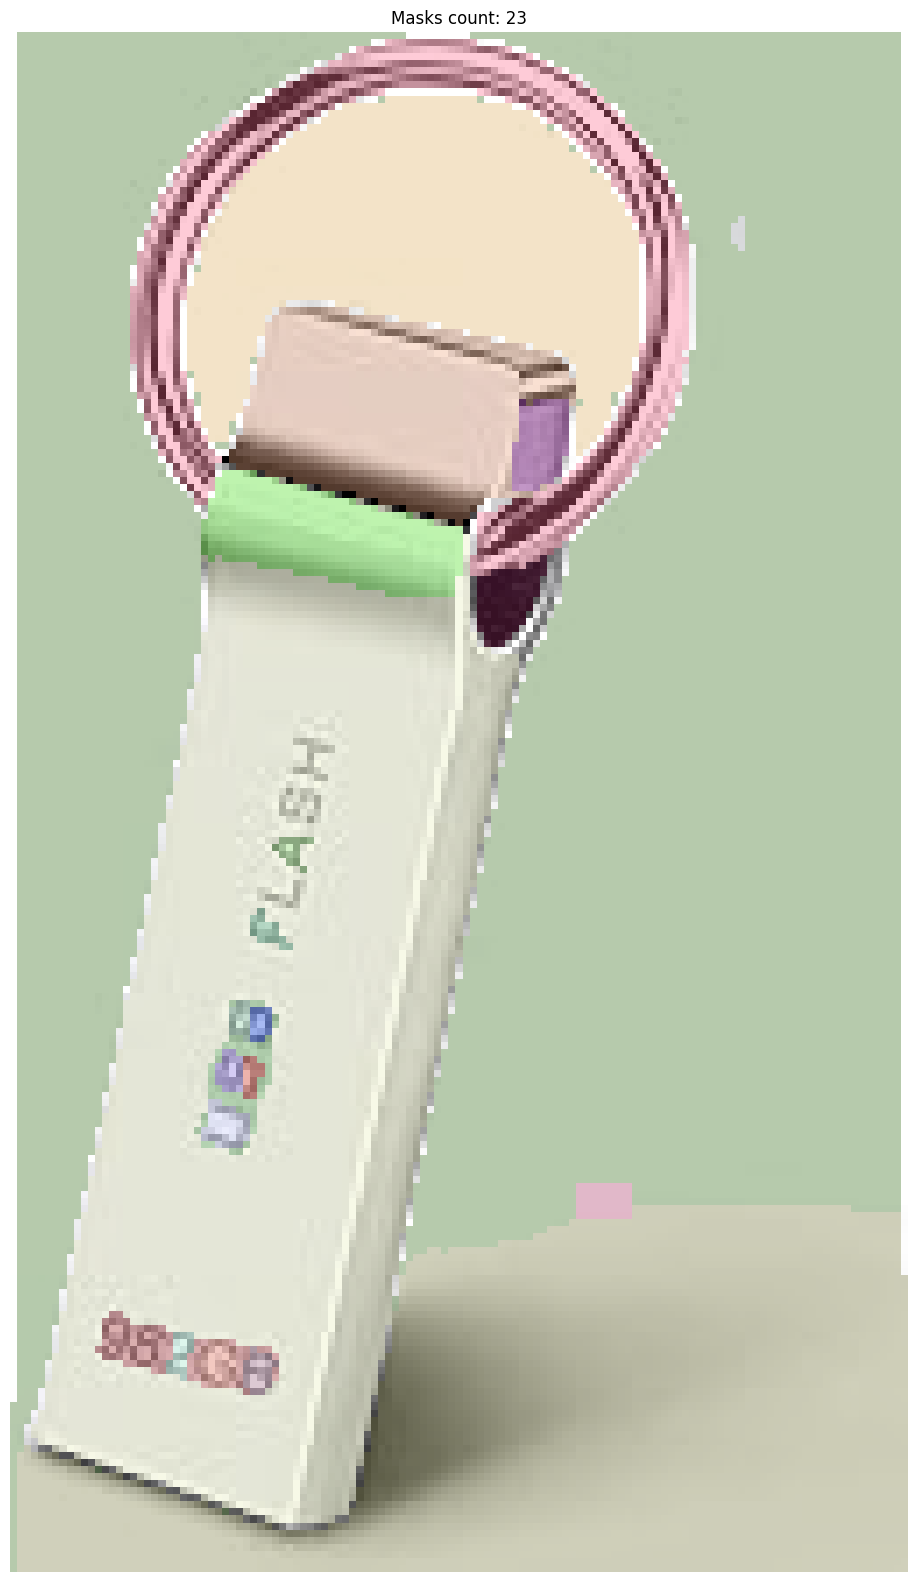

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.title(f'Masks count: {len(masks2)}') # Add title to plot
plt.show()

In [ ]:
# Sample less masks
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    # Default
    # points_per_side=32,
    # pred_iou_thresh=0.86,
    # stability_score_thresh=0.92,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,

    # Pensil config
    # points_per_side=8,
    # pred_iou_thresh=0.98,
    # stability_score_thresh=0.99,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,
    # min_mask_region_area=100,  # Requires open-cv to run post-processing

    # USB config
    points_per_side=32,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.98,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

In [ ]:
masks3 = mask_generator_3.generate(image)

In [ ]:
len(masks3) # Only one mask inside, the focus in whole image

2

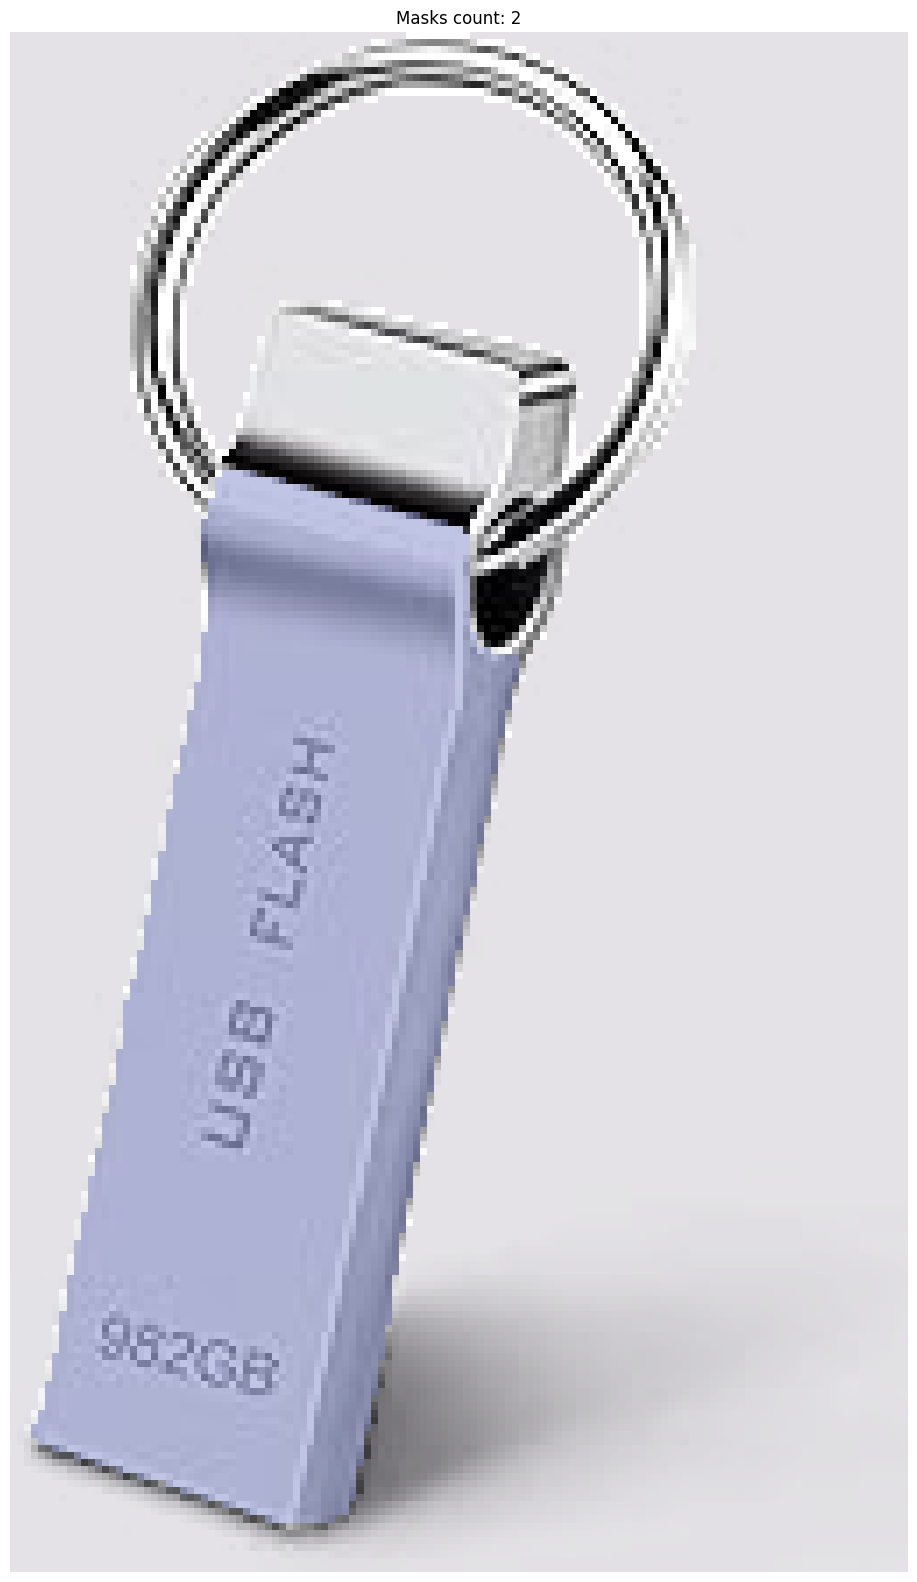

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.title(f'Masks count: {len(masks3)}') # Add title to plot
plt.show()

In [ ]:
def convert(lst):
    dic = {}
    for element in lst:
        dic[lst.index(element)] = element
    return dic

def convert_list_to_dict(lst):
  dictionary = {}
  dictionary = {k: v for d in lst for k, v in d.items()}
  return dictionary

# Print the mask shape in image format
if len(masks3) == 1:
    single_mask = True # Indicate only one mask on image
    print(masks3)
    print(type(masks3))
    # masks3 = dict(masks3)
    # Convert type:list to type:dictionary
    masks3_dict = convert_list_to_dict(masks3)
    print(masks3_dict)
    print(type(masks3_dict))
    print(masks3_dict.get('segmentation'))
    mask_shape = masks3_dict.get('segmentation')
else:
    single_mask = False
    print("Mask count more than 1")

Mask count more than 1


In [ ]:
# Plot mask shape in black white
if single_mask:
    plt.figure(figsize=(20,20))
    # plt.imshow(image)
    # show_anns(masks3)
    plt.imshow(mask_shape)
    plt.axis('off')
    # plt.title(f'Masks count: {len(masks3)}') # Add title to plot
    plt.savefig('mask_shape.png') # Save plot into folder
    plt.show()
else:
    print("Mask not single")

Mask not single


In [ ]:
# Show the saved mask image
mask_image = cv2.imread('mask_shape.png')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(mask_image)
plt.axis('off')
plt.show()

"""
The saved mask is the background instead of the object ifself.
So in order to get the target mask, reverse the saved mask.
"""

In [ ]:
# TODO: Automatic generate masks and save them as files locally
